
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh

____

# 🔴 **Import Libs**

In [7]:
!pip install datasets

In [8]:
!pip uninstall torchtext -y
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade torchdata
!pip install --upgrade torchtext --index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.3/838.3 MB 1.9 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 5.5 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 73.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.6 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.4 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.0 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 30.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from datasets import load_dataset

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from collections import Counter

import matplotlib.pyplot as plt
import torchmetrics
from torch.utils.data import Dataset
from torch.utils.data import DataLoader




In [10]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.2.0+cu118
0.17.0+cpu


In [11]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.2.0+cu118
torchtext --> 0.17.0+cpu
tqdm --> 4.66.5


# 🔴 **Utils**

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [14]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Access train, validation, and test splits
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

# Print the first 5 samples from each split
print("Train Data (First 5 lines):")
print(train_data[:5])

print("\nValidation Data (First 5 lines):")
print(valid_data[:5])

print("\nTest Data (First 5 lines):")
print(test_data[:5])

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Train Data (First 5 lines):
{'text': ['', ' = Valkyria Chronicles III = \n', '', ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n', " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [15]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for sample in data_iter:
        yield tokenizer(sample['text'])

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>", "<pad>", "<bos>", "<eos>"])

vocab.set_default_index(vocab["<unk>"])

print(f"Vocabulary size: {len(vocab)}")
print("Sample tokens from vocabulary:", vocab.lookup_tokens([20, 10, 100, 30]))

Vocabulary size: 66061
Sample tokens from vocabulary: ['for', 'to', 'being', 'his']


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [16]:
def calculate_statistics(data_iter, tokenizer):
    num_documents = 0
    total_words = 0
    document_lengths = []

    for sample in data_iter:
        tokens = tokenizer(sample['text'])
        num_documents += 1
        total_words += len(tokens)
        document_lengths.append(len(tokens))

    avg_document_length = total_words / num_documents if num_documents > 0 else 0

    return {
        "Number of Documents": num_documents,
        "Total Words": total_words,
        "Average Document Length": avg_document_length,
        "Max Document Length": max(document_lengths) if document_lengths else 0,
        "Min Document Length": min(document_lengths) if document_lengths else 0,
    }



In [17]:
train_stats = calculate_statistics(train_data, tokenizer)
valid_stats = calculate_statistics(valid_data, tokenizer)
test_stats = calculate_statistics(test_data, tokenizer)

print("Train Dataset Statistics:", train_stats)
print("Validation Dataset Statistics:", valid_stats)
print("Test Dataset Statistics:", test_stats)

Train Dataset Statistics: {'Number of Documents': 36718, 'Total Words': 2051665, 'Average Document Length': 55.87627321749551, 'Max Document Length': 696, 'Min Document Length': 0}
Validation Dataset Statistics: {'Number of Documents': 3760, 'Total Words': 214665, 'Average Document Length': 57.09175531914894, 'Max Document Length': 433, 'Min Document Length': 0}
Test Dataset Statistics: {'Number of Documents': 4358, 'Total Words': 242156, 'Average Document Length': 55.56585589720055, 'Max Document Length': 478, 'Min Document Length': 0}


### 🟡 Analyze the most common and least common words in the dataset.

In [18]:
def count_word_frequencies(data_iter, tokenizer):
    word_counter = Counter()
    for sample in data_iter:
        tokens = tokenizer(sample['text'])
        word_counter.update(tokens)
    return word_counter

word_frequencies = count_word_frequencies(train_data, tokenizer)

most_common_words = word_frequencies.most_common(10)

least_common_words = [(word, count) for word, count in word_frequencies.items() if count == 1]

print("Most Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

print("\nNumber of Least Common Words (Frequency=1):", len(least_common_words))
print("Sample Least Common Words (Frequency=1):")
print(least_common_words[:10])

Most Common Words:
the: 130770
,: 102624
.: 84291
of: 57032
and: 50736
in: 45018
to: 39522
a: 36564
=: 29570
was: 21008

Number of Least Common Words (Frequency=1): 26924
Sample Least Common Words (Frequency=1):
[('calamaty', 1), ('forgiving', 1), ('unvoiced', 1), ('scanned', 1), ('boosts', 1), ('depleting', 1), ('reila', 1), ('shocktroopers', 1), ('thereon', 1), ('altaha', 1)]


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

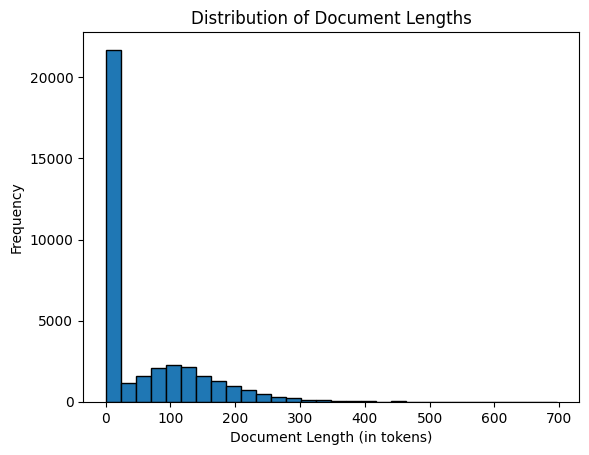

In [19]:
def plot_document_length_distribution(data_iter, tokenizer):
    document_lengths = [len(tokenizer(sample['text'])) for sample in data_iter]

    plt.hist(document_lengths, bins=30, edgecolor='k')
    plt.title("Distribution of Document Lengths")
    plt.xlabel("Document Length (in tokens)")
    plt.ylabel("Frequency")
    plt.show()

plot_document_length_distribution(train_data, tokenizer)

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [20]:
def data_process(raw_text_iter, batch_size, seq_len):
    all_tokens = []
    for sample in raw_text_iter:
        tokens = tokenizer(sample['text'])
        token_ids = vocab(tokens)
        all_tokens.extend(token_ids)

    data = torch.tensor(all_tokens, dtype=torch.long)
    num_batches = (len(data) - 1) // (batch_size * seq_len)
    data = data[:num_batches * batch_size * seq_len + 1]

    inputs = data[:-1].view(batch_size, -1)
    targets = data[1:].view(batch_size, -1)

    num_chunks = inputs.size(1) // seq_len
    inputs = inputs[:, :num_chunks * seq_len].contiguous().view(-1, seq_len)
    targets = targets[:, :num_chunks * seq_len].contiguous().view(-1, seq_len)

    return inputs, targets


In [21]:
batch_size = 32
seq_len = 50

train_inputs, train_targets = data_process(train_data, batch_size, seq_len)
valid_inputs, valid_targets = data_process(valid_data, batch_size, seq_len)
test_inputs, test_targets = data_process(test_data, batch_size, seq_len)

print(f"Train inputs shape: {train_inputs.shape}, Train targets shape: {train_targets.shape}")
print(f"Validation inputs shape: {valid_inputs.shape}, Validation targets shape: {valid_targets.shape}")
print(f"Test inputs shape: {test_inputs.shape}, Test targets shape: {test_targets.shape}")


Train inputs shape: torch.Size([41024, 50]), Train targets shape: torch.Size([41024, 50])
Validation inputs shape: torch.Size([4288, 50]), Validation targets shape: torch.Size([4288, 50])
Test inputs shape: torch.Size([4832, 50]), Test targets shape: torch.Size([4832, 50])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [22]:
class LanguageModelDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [23]:
train_dataset = LanguageModelDataset(train_inputs, train_targets)
valid_dataset = LanguageModelDataset(valid_inputs, valid_targets)
test_dataset = LanguageModelDataset(test_inputs, test_targets)

print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in validation dataset: {len(valid_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

sample_input, sample_target = train_dataset[0]
print(f"Sample input shape: {sample_input.shape}, Sample target shape: {sample_target.shape}")

Number of samples in train dataset: 41024
Number of samples in validation dataset: 4288
Number of samples in test dataset: 4832
Sample input shape: torch.Size([50]), Sample target shape: torch.Size([50])


## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [24]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_targets in train_loader:
    print(f"Train batch inputs shape: {batch_inputs.shape}, Train batch targets shape: {batch_targets.shape}")
    break

for batch_inputs, batch_targets in valid_loader:
    print(f"Validation batch inputs shape: {batch_inputs.shape}, Validation batch targets shape: {batch_targets.shape}")
    break

for batch_inputs, batch_targets in test_loader:
    print(f"Test batch inputs shape: {batch_inputs.shape}, Test batch targets shape: {batch_targets.shape}")
    break

Train batch inputs shape: torch.Size([32, 50]), Train batch targets shape: torch.Size([32, 50])
Validation batch inputs shape: torch.Size([32, 50]), Validation batch targets shape: torch.Size([32, 50])
Test batch inputs shape: torch.Size([32, 50]), Test batch targets shape: torch.Size([32, 50])


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [25]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
        super(LanguageModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src):
        embedded = self.embedding(src)

        lstm_out, _ = self.lstm(embedded)

        output = self.fc(lstm_out)

        return output


In [26]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.2

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)


# 🔴 **Config**

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [28]:
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.2
learning_rate = 0.001
num_epochs = 10

vocab_size = len(vocab)

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])  # Ignore padding in the loss computation

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

def calculate_perplexity(loss):
    return torch.exp(loss)

print(f"Model is on device: {device}")
print(f"Using optimizer: {optimizer}")
print(f"Loss function: {criterion}")


Model is on device: cuda
Using optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [29]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    model.train()
    loss_train = AverageMeter()  
    metric.reset()  

    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch:
                tepoch.set_description(f'Epoch {epoch}')

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  
            
            outputs = outputs.view(-1, outputs.size(-1))  
            targets = targets.view(-1)  

            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item(), n=len(targets))
            metric.update(outputs, targets)

            tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

    return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [30]:
def evaluate(model, test_loader, loss_fn, metric):
    model.eval()
    loss_eval = AverageMeter()  
    metric.reset()  

    with torch.inference_mode():  
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)  

            outputs = outputs.view(-1, outputs.size(-1))  
            targets = targets.view(-1)  

            loss = loss_fn(outputs, targets)
            loss_eval.update(loss.item(), n=len(targets))

            metric.update(outputs, targets)

    return loss_eval.avg, metric.compute().item()


# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [31]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(inputs)  

    outputs = outputs.view(-1, outputs.size(-1))  
    targets = targets.view(-1)  

    loss = criterion(outputs, targets)

print(f"Loss for an untrained model: {loss.item():.4f}")

Loss for an untrained model: 11.0990


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [32]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [33]:
small_subset_size = 100  
small_train_inputs = train_inputs[:small_subset_size]
small_train_targets = train_targets[:small_subset_size]

small_train_dataset = LanguageModelDataset(small_train_inputs, small_train_targets)
small_train_loader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)

metric = torchmetrics.Accuracy(task='multiclass', num_classes=vocab_size).to(device)


In [34]:
num_epochs = 10
for epoch in range(num_epochs):
    model, avg_loss, avg_metric = train_one_epoch(
        model,
        small_train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        metric=metric,
        epoch=epoch
    )
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Metric: {avg_metric:.4f}")

100%|██████████| 7/7 [00:00<00:00, 28.01batch/s, loss=11.1, metric=0.0032]  


Epoch 1/10, Loss: 11.0900, Metric: 0.0032


Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 36.09batch/s, loss=11, metric=0.0738]


Epoch 2/10, Loss: 11.0246, Metric: 0.0738


Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 36.39batch/s, loss=10.9, metric=0.0742]


Epoch 3/10, Loss: 10.9104, Metric: 0.0742


Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 36.51batch/s, loss=10.7, metric=0.0742]


Epoch 4/10, Loss: 10.7186, Metric: 0.0742


Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 36.39batch/s, loss=10.2, metric=0.0742]


Epoch 5/10, Loss: 10.2321, Metric: 0.0742


Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 36.38batch/s, loss=9.39, metric=0.0678]


Epoch 6/10, Loss: 9.3900, Metric: 0.0678


Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 36.46batch/s, loss=8.94, metric=0.0374]


Epoch 7/10, Loss: 8.9403, Metric: 0.0374


Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 36.45batch/s, loss=8.49, metric=0.0694]


Epoch 8/10, Loss: 8.4917, Metric: 0.0694


Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 36.16batch/s, loss=8.19, metric=0.0572]


Epoch 9/10, Loss: 8.1865, Metric: 0.0572


Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 36.07batch/s, loss=7.92, metric=0.0556]

Epoch 10/10, Loss: 7.9157, Metric: 0.0556


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [29]:
num_epochs = 5

learning_rates = [0.01, 0.05, 0.1]

for lr in learning_rates:
    print(f'LR={lr}')

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

    for epoch in range(num_epochs):
        model, avg_loss, avg_metric = train_one_epoch(
            model=model,
            train_loader=train_loader,
            loss_fn=criterion,
            optimizer=optimizer,
            metric=metric,
            epoch=epoch
        )
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Metric: {avg_metric:.4f}')

    print()  

LR=0.01


100%|██████████| 1282/1282 [01:00<00:00, 21.10batch/s, loss=8.44, metric=0.0622]


Epoch 1/5, Loss: 8.4350, Metric: 0.0622


Epoch 1: 100%|██████████| 1282/1282 [01:02<00:00, 20.67batch/s, loss=7.45, metric=0.0709]


Epoch 2/5, Loss: 7.4478, Metric: 0.0709


Epoch 2: 100%|██████████| 1282/1282 [01:02<00:00, 20.68batch/s, loss=7.26, metric=0.0928]


Epoch 3/5, Loss: 7.2640, Metric: 0.0928


Epoch 3: 100%|██████████| 1282/1282 [01:02<00:00, 20.61batch/s, loss=7.14, metric=0.107]


Epoch 4/5, Loss: 7.1364, Metric: 0.1065


Epoch 4: 100%|██████████| 1282/1282 [01:02<00:00, 20.66batch/s, loss=7.04, metric=0.116]


Epoch 5/5, Loss: 7.0449, Metric: 0.1156

LR=0.05


100%|██████████| 1282/1282 [01:00<00:00, 21.06batch/s, loss=7.54, metric=0.0919]


Epoch 1/5, Loss: 7.5427, Metric: 0.0919


Epoch 1: 100%|██████████| 1282/1282 [01:02<00:00, 20.67batch/s, loss=6.83, metric=0.134]


Epoch 2/5, Loss: 6.8313, Metric: 0.1338


Epoch 2: 100%|██████████| 1282/1282 [01:01<00:00, 20.70batch/s, loss=6.67, metric=0.146]


Epoch 3/5, Loss: 6.6697, Metric: 0.1457


Epoch 3: 100%|██████████| 1282/1282 [01:01<00:00, 20.71batch/s, loss=6.58, metric=0.152]


Epoch 4/5, Loss: 6.5811, Metric: 0.1523


Epoch 4: 100%|██████████| 1282/1282 [01:01<00:00, 20.71batch/s, loss=6.52, metric=0.157]


Epoch 5/5, Loss: 6.5192, Metric: 0.1571

LR=0.1


100%|██████████| 1282/1282 [01:00<00:00, 21.11batch/s, loss=7.28, metric=0.107] 


Epoch 1/5, Loss: 7.2768, Metric: 0.1066


Epoch 1: 100%|██████████| 1282/1282 [01:01<00:00, 20.70batch/s, loss=6.67, metric=0.145]


Epoch 2/5, Loss: 6.6673, Metric: 0.1455


Epoch 2: 100%|██████████| 1282/1282 [01:02<00:00, 20.68batch/s, loss=6.52, metric=0.156]


Epoch 3/5, Loss: 6.5242, Metric: 0.1565


Epoch 3: 100%|██████████| 1282/1282 [01:02<00:00, 20.66batch/s, loss=6.43, metric=0.163]


Epoch 4/5, Loss: 6.4347, Metric: 0.1630


Epoch 4: 100%|██████████| 1282/1282 [01:02<00:00, 20.62batch/s, loss=6.37, metric=0.167]

Epoch 5/5, Loss: 6.3685, Metric: 0.1674



### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [35]:
num_epochs = 5

best_learning_rate = 0.1  

learning_rates = [best_learning_rate]
weight_decays = [1e-4, 5e-4, 1e-3, 5e-3]  

for lr in learning_rates:
    for wd in weight_decays:
        print(f'LR={lr}, WD={wd}')

        model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

        for epoch in range(num_epochs):
            model, avg_loss, avg_metric = train_one_epoch(
                model=model,
                train_loader=train_loader,
                loss_fn=criterion,
                optimizer=optimizer,
                metric=metric,
                epoch=epoch
            )
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Metric: {avg_metric:.4f}')

        print()

LR=0.1, WD=0.0001


100%|██████████| 1282/1282 [01:01<00:00, 20.93batch/s, loss=7.27, metric=0.108]


Epoch 1/5, Loss: 7.2747, Metric: 0.1079


Epoch 1: 100%|██████████| 1282/1282 [01:02<00:00, 20.46batch/s, loss=6.67, metric=0.146]


Epoch 2/5, Loss: 6.6699, Metric: 0.1464


Epoch 2: 100%|██████████| 1282/1282 [01:02<00:00, 20.54batch/s, loss=6.53, metric=0.156]


Epoch 3/5, Loss: 6.5295, Metric: 0.1563


Epoch 3: 100%|██████████| 1282/1282 [01:01<00:00, 20.70batch/s, loss=6.44, metric=0.163]


Epoch 4/5, Loss: 6.4392, Metric: 0.1627


Epoch 4: 100%|██████████| 1282/1282 [01:02<00:00, 20.67batch/s, loss=6.38, metric=0.167]


Epoch 5/5, Loss: 6.3761, Metric: 0.1666

LR=0.1, WD=0.0005


100%|██████████| 1282/1282 [01:00<00:00, 21.11batch/s, loss=7.31, metric=0.102] 


Epoch 1/5, Loss: 7.3146, Metric: 0.1017


Epoch 1: 100%|██████████| 1282/1282 [01:01<00:00, 20.72batch/s, loss=6.8, metric=0.134] 


Epoch 2/5, Loss: 6.7978, Metric: 0.1344


Epoch 2: 100%|██████████| 1282/1282 [01:01<00:00, 20.70batch/s, loss=6.7, metric=0.143] 


Epoch 3/5, Loss: 6.7017, Metric: 0.1428


Epoch 3: 100%|██████████| 1282/1282 [01:01<00:00, 20.70batch/s, loss=6.63, metric=0.148]


Epoch 4/5, Loss: 6.6332, Metric: 0.1484


Epoch 4: 100%|██████████| 1282/1282 [01:01<00:00, 20.71batch/s, loss=6.57, metric=0.155]


Epoch 5/5, Loss: 6.5716, Metric: 0.1550

LR=0.1, WD=0.001


100%|██████████| 1282/1282 [01:00<00:00, 21.13batch/s, loss=7.4, metric=0.0939] 


Epoch 1/5, Loss: 7.3957, Metric: 0.0939


Epoch 1: 100%|██████████| 1282/1282 [01:01<00:00, 20.71batch/s, loss=6.93, metric=0.124]


Epoch 2/5, Loss: 6.9325, Metric: 0.1239


Epoch 2: 100%|██████████| 1282/1282 [01:01<00:00, 20.72batch/s, loss=6.85, metric=0.133]


Epoch 3/5, Loss: 6.8478, Metric: 0.1328


Epoch 3: 100%|██████████| 1282/1282 [01:01<00:00, 20.69batch/s, loss=6.8, metric=0.138]


Epoch 4/5, Loss: 6.8002, Metric: 0.1384


Epoch 4: 100%|██████████| 1282/1282 [01:01<00:00, 20.70batch/s, loss=6.78, metric=0.143]


Epoch 5/5, Loss: 6.7769, Metric: 0.1428

LR=0.1, WD=0.005


100%|██████████| 1282/1282 [01:00<00:00, 21.15batch/s, loss=7.7, metric=0.0576] 


Epoch 1/5, Loss: 7.7037, Metric: 0.0576


Epoch 1: 100%|██████████| 1282/1282 [01:01<00:00, 20.75batch/s, loss=7.52, metric=0.0574]


Epoch 2/5, Loss: 7.5154, Metric: 0.0574


Epoch 2: 100%|██████████| 1282/1282 [01:01<00:00, 20.75batch/s, loss=7.52, metric=0.0575]


Epoch 3/5, Loss: 7.5163, Metric: 0.0575


Epoch 3: 100%|██████████| 1282/1282 [01:01<00:00, 20.72batch/s, loss=7.51, metric=0.0575]


Epoch 4/5, Loss: 7.5119, Metric: 0.0575


Epoch 4: 100%|██████████| 1282/1282 [01:01<00:00, 20.76batch/s, loss=7.51, metric=0.0576]

Epoch 5/5, Loss: 7.5133, Metric: 0.0576



### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [36]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

In [37]:
lr = 0.1  
wd = 1e-4  

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)


In [38]:
loss_train_hist = []
loss_valid_hist = []
metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [39]:
num_epochs = 25

for epoch in range(num_epochs):
    model, loss_train, metric_train = train_one_epoch(
        model=model,
        train_loader=train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        metric=metric,
        epoch=epoch
    )

    loss_valid, metric_valid = evaluate(
        model=model,
        test_loader=valid_loader,
        loss_fn=criterion,
        metric=metric
    )

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)

    if loss_valid < best_loss_valid:
        torch.save(model.state_dict(), f'model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train: Loss = {loss_train:.4f}, Metric = {metric_train:.4f}')
    print(f'Valid: Loss = {loss_valid:.4f}, Metric = {metric_valid:.4f}')
    print()

    epoch_counter += 1

100%|██████████| 1282/1282 [01:01<00:00, 20.88batch/s, loss=7.24, metric=0.109]


Model Saved!
Epoch 1/25
Train: Loss = 7.2398, Metric = 0.1089
Valid: Loss = 6.8014, Metric = 0.1435



Epoch 1: 100%|██████████| 1282/1282 [01:02<00:00, 20.45batch/s, loss=6.67, metric=0.147]


Model Saved!
Epoch 2/25
Train: Loss = 6.6668, Metric = 0.1471
Valid: Loss = 6.6350, Metric = 0.1557



Epoch 2: 100%|██████████| 1282/1282 [01:02<00:00, 20.47batch/s, loss=6.53, metric=0.158]


Model Saved!
Epoch 3/25
Train: Loss = 6.5265, Metric = 0.1584
Valid: Loss = 6.5287, Metric = 0.1681



Epoch 3: 100%|██████████| 1282/1282 [01:02<00:00, 20.44batch/s, loss=6.44, metric=0.164]


Model Saved!
Epoch 4/25
Train: Loss = 6.4393, Metric = 0.1644
Valid: Loss = 6.4640, Metric = 0.1708



Epoch 4: 100%|██████████| 1282/1282 [01:02<00:00, 20.42batch/s, loss=6.38, metric=0.168]


Model Saved!
Epoch 5/25
Train: Loss = 6.3769, Metric = 0.1684
Valid: Loss = 6.4273, Metric = 0.1744



Epoch 5: 100%|██████████| 1282/1282 [01:02<00:00, 20.44batch/s, loss=6.33, metric=0.171]


Model Saved!
Epoch 6/25
Train: Loss = 6.3283, Metric = 0.1714
Valid: Loss = 6.3778, Metric = 0.1796



Epoch 6: 100%|██████████| 1282/1282 [01:02<00:00, 20.47batch/s, loss=6.29, metric=0.174]


Model Saved!
Epoch 7/25
Train: Loss = 6.2877, Metric = 0.1742
Valid: Loss = 6.3439, Metric = 0.1819



Epoch 7: 100%|██████████| 1282/1282 [01:02<00:00, 20.47batch/s, loss=6.25, metric=0.177]


Model Saved!
Epoch 8/25
Train: Loss = 6.2528, Metric = 0.1766
Valid: Loss = 6.3184, Metric = 0.1836



Epoch 8: 100%|██████████| 1282/1282 [01:02<00:00, 20.48batch/s, loss=6.22, metric=0.179]


Model Saved!
Epoch 9/25
Train: Loss = 6.2207, Metric = 0.1788
Valid: Loss = 6.2861, Metric = 0.1860



Epoch 9: 100%|██████████| 1282/1282 [01:02<00:00, 20.46batch/s, loss=6.19, metric=0.181]


Model Saved!
Epoch 10/25
Train: Loss = 6.1918, Metric = 0.1808
Valid: Loss = 6.2720, Metric = 0.1883



Epoch 10: 100%|██████████| 1282/1282 [01:02<00:00, 20.44batch/s, loss=6.16, metric=0.183]


Model Saved!
Epoch 11/25
Train: Loss = 6.1641, Metric = 0.1829
Valid: Loss = 6.2429, Metric = 0.1891



Epoch 11: 100%|██████████| 1282/1282 [01:02<00:00, 20.43batch/s, loss=6.14, metric=0.185]


Model Saved!
Epoch 12/25
Train: Loss = 6.1357, Metric = 0.1847
Valid: Loss = 6.2276, Metric = 0.1891



Epoch 12: 100%|██████████| 1282/1282 [01:02<00:00, 20.43batch/s, loss=6.11, metric=0.187]


Model Saved!
Epoch 13/25
Train: Loss = 6.1077, Metric = 0.1867
Valid: Loss = 6.2022, Metric = 0.1916



Epoch 13: 100%|██████████| 1282/1282 [01:02<00:00, 20.41batch/s, loss=6.07, metric=0.189]


Model Saved!
Epoch 14/25
Train: Loss = 6.0735, Metric = 0.1895
Valid: Loss = 6.1691, Metric = 0.1946



Epoch 14: 100%|██████████| 1282/1282 [01:02<00:00, 20.41batch/s, loss=6.04, metric=0.192]


Model Saved!
Epoch 15/25
Train: Loss = 6.0376, Metric = 0.1923
Valid: Loss = 6.1345, Metric = 0.1973



Epoch 15: 100%|██████████| 1282/1282 [01:02<00:00, 20.37batch/s, loss=6, metric=0.195]  


Model Saved!
Epoch 16/25
Train: Loss = 5.9990, Metric = 0.1952
Valid: Loss = 6.1073, Metric = 0.1973



Epoch 16: 100%|██████████| 1282/1282 [01:02<00:00, 20.44batch/s, loss=5.96, metric=0.198]


Model Saved!
Epoch 17/25
Train: Loss = 5.9632, Metric = 0.1976
Valid: Loss = 6.0774, Metric = 0.2024



Epoch 17: 100%|██████████| 1282/1282 [01:02<00:00, 20.36batch/s, loss=5.93, metric=0.201]


Model Saved!
Epoch 18/25
Train: Loss = 5.9250, Metric = 0.2008
Valid: Loss = 6.0452, Metric = 0.2039



Epoch 18: 100%|██████████| 1282/1282 [01:03<00:00, 20.33batch/s, loss=5.89, metric=0.203]


Model Saved!
Epoch 19/25
Train: Loss = 5.8923, Metric = 0.2029
Valid: Loss = 6.0288, Metric = 0.2041



Epoch 19: 100%|██████████| 1282/1282 [01:02<00:00, 20.41batch/s, loss=5.86, metric=0.205]


Model Saved!
Epoch 20/25
Train: Loss = 5.8599, Metric = 0.2054
Valid: Loss = 6.0163, Metric = 0.2048



Epoch 20: 100%|██████████| 1282/1282 [01:02<00:00, 20.46batch/s, loss=5.83, metric=0.207]


Model Saved!
Epoch 21/25
Train: Loss = 5.8330, Metric = 0.2072
Valid: Loss = 5.9748, Metric = 0.2088



Epoch 21: 100%|██████████| 1282/1282 [01:02<00:00, 20.45batch/s, loss=5.8, metric=0.209]


Model Saved!
Epoch 22/25
Train: Loss = 5.8040, Metric = 0.2094
Valid: Loss = 5.9590, Metric = 0.2100



Epoch 22: 100%|██████████| 1282/1282 [01:02<00:00, 20.46batch/s, loss=5.78, metric=0.211]


Model Saved!
Epoch 23/25
Train: Loss = 5.7787, Metric = 0.2115
Valid: Loss = 5.9413, Metric = 0.2125



Epoch 23: 100%|██████████| 1282/1282 [01:02<00:00, 20.45batch/s, loss=5.75, metric=0.213]


Model Saved!
Epoch 24/25
Train: Loss = 5.7539, Metric = 0.2130
Valid: Loss = 5.9274, Metric = 0.2130



Epoch 24: 100%|██████████| 1282/1282 [01:02<00:00, 20.48batch/s, loss=5.73, metric=0.215]


Epoch 25/25
Train: Loss = 5.7317, Metric = 0.2148
Valid: Loss = 5.9415, Metric = 0.2119



## 🟠 Main Loop

🔰 Define model.

In [ ]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
lr = 0.1  
wd = 1e-4  

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)


🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []
metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    model, loss_train, metric_train = train_one_epoch(
        model=model,
        train_loader=train_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        metric=metric,
        epoch=epoch
    )

    loss_valid, metric_valid = evaluate(
        model=model,
        test_loader=valid_loader,
        loss_fn=criterion,
        metric=metric
    )

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)

    if loss_valid < best_loss_valid:
        torch.save(model.state_dict(), f'model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train: Loss = {loss_train:.4f}, Metric = {metric_train:.4f}')
    print(f'Valid: Loss = {loss_valid:.4f}, Metric = {metric_valid:.4f}')
    print()

    epoch_counter += 1

## 🟠 Plot

🔰 Plot learning curves

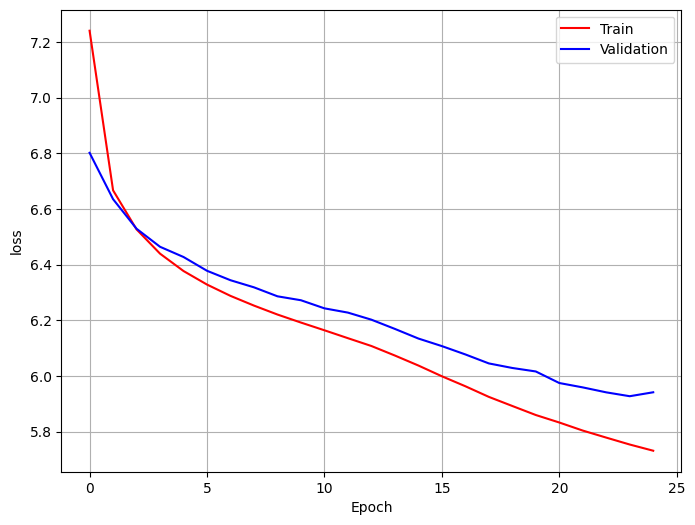

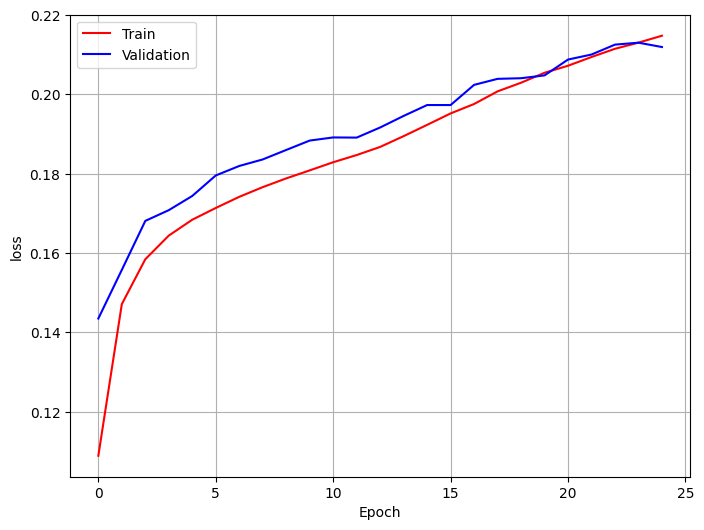

In [41]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), metric_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [42]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
model.load_state_dict(torch.load('model.pt'))

model.eval()

loss_test, metric_test = evaluate(
    model=model,
    test_loader=test_loader,
    loss_fn=criterion,
    metric=metric
)

print(f'Test Results: Loss = {loss_test:.4f}, Metric = {metric_test:.4f}')

Test Results: Loss = 5.9561, Metric = 0.2109


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [44]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
model.load_state_dict(torch.load('model.pt'))

model.eval()

LanguageModel(
  (embedding): Embedding(66061, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=66061, bias=True)
)

In [45]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    tokens = tokenizer(prompt)
    input_ids = torch.tensor([vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(device)

    model.eval()
    generated_tokens = []

    with torch.inference_mode():
        for _ in range(max_seq_len):
            outputs = model(input_ids)

            logits = outputs[:, -1, :]  

            logits = logits / temperature

            probabilities = torch.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1).item()

            generated_tokens.append(next_token_id)

            input_ids = torch.cat([input_ids, torch.tensor([[next_token_id]], device=device)], dim=1)

            if next_token_id == vocab["<eos>"]:
                break

    generated_text = " ".join(vocab.lookup_tokens(generated_tokens))
    return generated_text

In [51]:
prompt = "me and my homies had a good day"
max_seq_len = 10
temperature = 1.0

generated_text = generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=42)

print("Generated Text:")
print(generated_text)

Generated Text:
. though in much protocol fallen , a job remained
